# Diabetes risk factors
(Mathematical Statistics Homework Project)

**Viktória Nemkin (M8GXSS)**

I am interested in medical research, so I have chosen the [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) from Kaggle as the topic of my homework project. The goal of this dataset is to predict whether someone will develop diabetes, based on key indicators of the disease.

## Input data

The dataset is anonymised and contains the following data about 100,000 individuals:

- **Age**: Ranges from 0-80, diabetes is more common amongst older adults.
- **Gender**: Can also have an impact on a person's susceptibility.
- **Body Mass Index (BMI)**: Higher BMI values are linked to higher diabetes risk.
- **Hypertension**: Presistently elevated blood pressure in the arteries, linked to heart disease.
- **Heart disease**: Associated with a risk of developing diabetes.
- **Smoking history**: Considered as a risk factor, can worsen the complications of diabetes.
- **HbA1c level**: Hemoglobin A1c, measures blood sugar level over the past 2-3 months. Over 6.5% indicates diabetes.
- **Blood glucose level**: Key indicator of diabetes.
- **Diabetes**: Target value.

These are some of the key indicators of diabetes, along with demographic data, which could be used to determine risk factors for developing diabetes.

## Tools

I used Python, the `numpy` and `pandas` libraries for manipulation of the dataset, `matplotlib` for plotting and `scikit-learn` for the various statistical analysis and evaluation tools it offers.

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data cleaning and sanity checks

The first step in working with data is making sure it is not flawed. There
is no single correct way to do this, but some sanity checks can be performed
and typical problems eliminated during cleaning.

In [145]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

For instance, we want to make sure that the columns are correctly typed.
I have noticed, that some of them were incorrect, so I made the following
fixes.

In [146]:
df['age'] = df['age'].astype(int)
df['gender'] = df['gender'].astype('category')
df['smoking_history'] = df['smoking_history'].astype('category')
df['hypertension'] = df['hypertension'].astype(bool)
df['heart_disease'] = df['heart_disease'].astype(bool)
df['diabetes'] = df['diabetes'].astype(bool)

I have also noticed inconsistent category names in `smoking_history`, so I made the following fixes.

In [147]:
df['smoking_history'] = df['smoking_history'].replace({'No Info': 'no_info', 'not current': 'not_current'})

Furthermore, I noticed some problems with the BMI values in the dataset.

To investigate this further, I plotted a histogram of the values on a logarithmic scale in the following diagram.

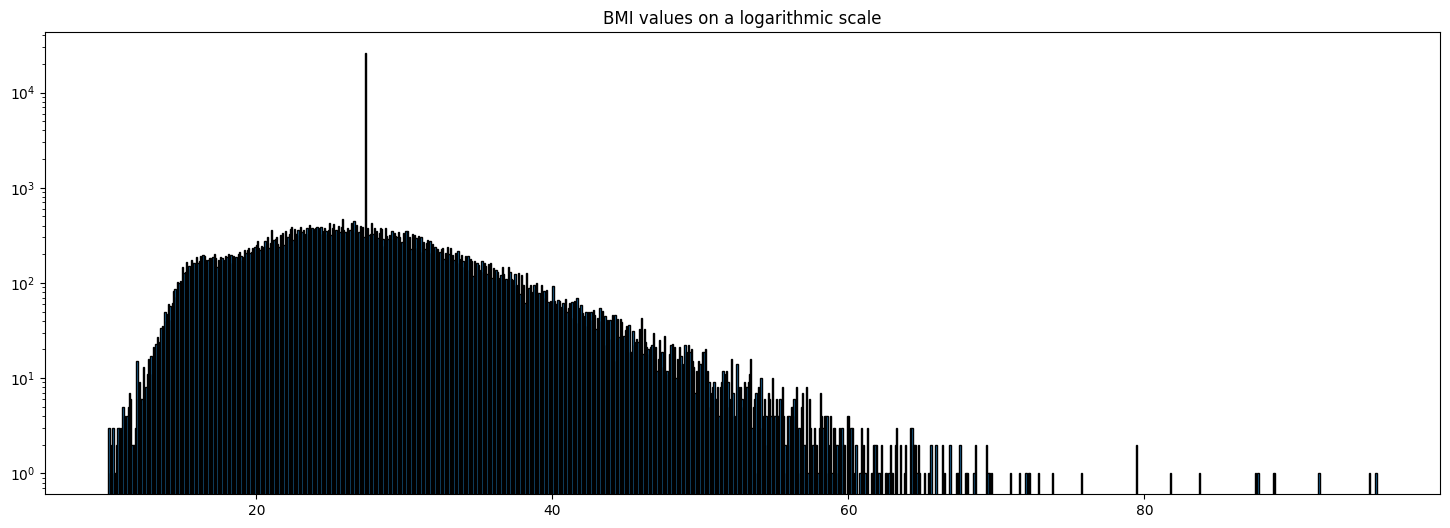

In [148]:
values = df_encoded['bmi']
counts, bins, _ = plt.hist(values, bins=1000, edgecolor='black')

plt.title("BMI values on a logarithmic scale")
plt.yscale('log')

plt.gcf().set_size_inches(18, 6)
plt.show()


A BMI above 70 is such an extreme and rare case, that I believe it will only worsen our prediction for the general case. I will remove these outlier values from the dataset.

That singular peak in one of the bins is also concerning. I kept increasing the granuality and it never disappears. Let us check the most common values in the dataset!

In [149]:
max_count_bin = np.argmax(counts)
max_count = counts[max_count_bin]
max_bin_range = (bins[max_count_bin], bins[max_count_bin + 1])

max_bin_range

unique_values, counts = np.unique(values, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
sorted_values = unique_values[sorted_indices]
sorted_counts = counts[sorted_indices]

top_10_values = sorted_values[:10]
top_10_counts = sorted_counts[:10]

print(top_10_values)
print(top_10_counts)


[27.32 23.   27.12 27.8  24.96 22.4  25.   25.6  26.7  24.5 ]
[25495   103   101   100   100    99    99    98    94    94]


For some reason, we have over $\frac{1}{4}$ entries of the dataset with the exact BMI of 27.32?

In [150]:
weird_entries = df[df['bmi'] == 27.32]

weird_entries.head(20)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
1,Female,54,False,False,no_info,27.32,6.6,80,False
2,Male,28,False,False,never,27.32,5.7,158,False
5,Female,20,False,False,never,27.32,6.6,85,False
9,Female,32,False,False,never,27.32,5.0,100,False
10,Female,53,False,False,never,27.32,6.1,85,False
14,Female,76,False,False,no_info,27.32,5.0,160,False
15,Male,78,False,False,no_info,27.32,6.6,126,False
18,Female,42,False,False,no_info,27.32,5.7,80,False
26,Male,67,False,True,not_current,27.32,6.5,200,True
38,Male,50,True,False,current,27.32,5.7,260,True


These all seem like real entries, not duplicates of the same entry. In a real life scenario, I would clarify this with the person who gave me this dataset, but right now I will accept these rows.

Finally, I checked that no values were missing.

In [151]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

If there were missing values, we could drop them with `df.dropna(inplace=True)`, but it is not needed.

## Understanding our data

We can now explore our clean dataset!

First, we can look at the first few rows.

In [152]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80,False,True,never,25.19,6.6,140,False
1,Female,54,False,False,no_info,27.32,6.6,80,False
2,Male,28,False,False,never,27.32,5.7,158,False
3,Female,36,False,False,current,23.45,5.0,155,False
4,Male,76,True,True,current,20.14,4.8,155,False


The column types are now correct.

In [153]:
df.dtypes

gender                 category
age                       int32
hypertension               bool
heart_disease              bool
smoking_history        category
bmi                     float64
HbA1c_level             float64
blood_glucose_level       int64
diabetes                   bool
dtype: object

The numerical values can be checked with `df.describe()`.

It looks like the age parameter is relative evenly distributed.

The average BMI falls into the overweight category, with extremes on both ends (BMI of 10 and 97). We should keep this in mind for later, as it could improve our detection to drop these outliers.

Although it is not explicitly stated, blood sugar levels are likely measured after fasting, for which 4.4 - 5.5 is a normal range, 5.6 - 6.9 is elevated and 7.0 and above is high.

In [154]:
df.describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.875660,27.320767,5.527507,138.058060
std,22.535417,6.636783,1.070672,40.708136
min,0.000000,10.010000,3.500000,80.000000
25%,24.000000,23.630000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,60.000000,29.580000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


In [155]:
columns = df.select_dtypes(include='category').columns.tolist()

for column in columns:
    values = sorted(list(df[column].unique()))
    print(column)
    print(values)
    print()

gender
['Female', 'Male', 'Other']

smoking_history
['current', 'ever', 'former', 'never', 'no_info', 'not_current']



Age should be an integer, gender and smoking history should be categorical.

In [156]:
df.dtypes

gender                 category
age                       int32
hypertension               bool
heart_disease              bool
smoking_history        category
bmi                     float64
HbA1c_level             float64
blood_glucose_level       int64
diabetes                   bool
dtype: object

## Multivariate linear regression

In [157]:
df_encoded = pd.get_dummies(df)
X = df_encoded.drop('diabetes', axis=1)
X.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Female,gender_Male,gender_Other,smoking_history_no_info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not_current
0,80,False,True,25.19,6.6,140,True,False,False,False,False,False,False,True,False
1,54,False,False,27.32,6.6,80,True,False,False,True,False,False,False,False,False
2,28,False,False,27.32,5.7,158,False,True,False,False,False,False,False,True,False
3,36,False,False,23.45,5.0,155,True,False,False,False,True,False,False,False,False
4,76,True,True,20.14,4.8,155,False,True,False,False,True,False,False,False,False


In [158]:
y = df_encoded['diabetes']
y.head()

0    False
1    False
2    False
3    False
4    False
Name: diabetes, dtype: bool

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [160]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.051180377272048494


In [161]:
# Display the model's coefficients and intercept
coefficients = pd.DataFrame({'Variable': X.columns, 'Coefficient': model.coef_})
intercept = pd.DataFrame({'Variable': ['Intercept'], 'Coefficient': model.intercept_})

print("Coefficients:")
print(coefficients)
print("\nIntercept:")
print(intercept)

Coefficients:
                       Variable  Coefficient
0                           age     0.001336
1                  hypertension     0.092471
2                 heart_disease     0.118214
3                           bmi     0.004055
4                   HbA1c_level     0.081449
5           blood_glucose_level     0.002275
6                 gender_Female     0.011399
7                   gender_Male     0.024079
8                  gender_Other    -0.035478
9       smoking_history_no_info    -0.011962
10      smoking_history_current    -0.001451
11         smoking_history_ever    -0.003983
12       smoking_history_former     0.015201
13        smoking_history_never    -0.002184
14  smoking_history_not_current     0.004379

Intercept:
    Variable  Coefficient
0  Intercept    -0.870916


Forrás: https://www.geeksforgeeks.org/multiple-linear-regression-with-scikit-learn/

In [162]:
correlation_matrix = df.corr()

print("Correlation Matrix:")
print(correlation_matrix)


ValueError: could not convert string to float: 'never'